In [ ]:
import glob
import os
import warnings
from collections import Counter, defaultdict

import hdbscan
import numpy as np
import pandas as pd
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from utils import process_dataset, process_trials_for_dataset

## Importing Data

### Initial Files Given

1. Initially these are the files that were provided to us. These files were retrieved from VoicePrivacy2024 (Link). There are two folders - dev-clean and test-clean and each have these contents:
   - **Enroll File:** Contains audio data for enrollment, used to generate speaker embeddings. Each embedding represents a unique speaker ID.
   - **Trials File:** Contains audio data (utterance IDs) that we test against.
   - **Trials CSV:** Provides ground truth information, including speaker IDs, utterance IDs, and target labels (whether utterance ID match with speaker ID or not).
   - **Spk2Utt CSV:** Maps speakers to their corresponding utterance IDs, offering a summarized reference for which utterances belong to each speaker.

### Purpose of Each File

- **Enroll:**  
  We use this file to create speaker embeddings. Each resulting embedding uniquely represents a speaker.

- **Trials:**  
  Contains all the audio recordings identified by utterance ID that will be used during testing.

- **Trials CSV:**  
  Acts as the ground truth, containing details such as speaker ID, utterance ID, and target labels to validate our predictions.

- **Spk2Utt:**  
  Provides a clear mapping of which speaker is associated with which utterance, making it easier to review and summarize speaker information.

### Embedding Extraction Process

With the audio data that we have, we extracted the embeddings in order to process them in our classical machine learning model.

1. **Voiceprint Embeddings (ECAPA-TDNN):**  
   Extracted from the audio data in order to capture the speaker’s unique vocal characteristics.

2. **Prosody Embeddings (Tacotron2):**  
   Extracted to capture the stylistic and rhythmic aspects of speech. While voiceprint embeddings alone are usually sufficient for speaker identification, prosody embeddings are included based on research indicating that a person’s speaking style (stylometry) can further improve identification accuracy (Research Paper Link - https://arxiv.org/pdf/2210.17222)

*For details on these extraction processes, please refer to the corresponding notebooks: one for ECAPA-TDNN and one for Tacotron2 (Tacatron_Prosody_Extraction.ipynb).*
- extraction_models\ECPA_TDNN.ipynb
- extraction_models\Tacatron_Prosody_Extraction.ipynb

### Combining Embeddings

After extracting both sets of embeddings, we combine them to compute the average embedding representation for each speaker. This consolidated representation helps in creating a robust profile for each speaker.

The code below is how we combined them, by finding the mean.

''
avg_embedding = np.mean(np.vstack(embeddings), axis=0)
''

### Data Splitting

The dataset is split into three distinct sets:

- **Training Set:**  28710 samples
  Contains data from a unique set of speakers. Used for model learning without any data leakage from testing speakers.

- **Validation Set:**  1500 samples
  This set is used for hyperparameter optimization to fine-tune the model performance.

- **Test Set:**  21650 samples
  The test set is large and does not follow the convention 70/15/15 split as to ensure a fair comparison with previous research. So we used the same test set so we can fairly compare the two results. This is the research paper compared with (https://drive.google.com/file/d/10_YiiOx0SQNXrPt9LLUBzjKQ5SzFrzqt/view?usp=drive_link). The test set is separate from both the training and validation sets to avoid data leakage.

The below code then imports these splitted datasets, together with the trial and spk2utt dataframes.

In [ ]:
import os
import pandas as pd

# === Global Configuration ===
BASE_PATH = ""

# Datasets and Modalities
DATASETS = ['training_set', 'validation_set', 'test_set']
MODALITIES = {
    'voiceprint': 'voiceprint_ecapa_tdnn',
    'prosody': 'prosody_tacotron'
}

# Storage Dictionaries
trials_dfs = {}
spk2utt_dfs = {}
folder_paths = {}

for dataset in DATASETS:
    process_dataset(dataset)

# At this point:
# - 'trials_dfs' and 'spk2utt_dfs' contain the DataFrames for each dataset.
# - 'folder_paths' contains the paths to speaker embeddings and trial embeddings for each dataset and modality.

training_set - Voiceprint:
    Combined speaker embeddings (enroll_path) file count: 29
    Speaker embeddings (speaker_emb_path) file count: 343
    Trial embeddings file count: 1978
training_set - Prosody:
    Combined speaker embeddings (enroll_path) file count: 29
    Speaker embeddings (speaker_emb_path) file count: 0
    Trial embeddings file count: 1978
training_set trials.csv shape: (28710, 3)
training_set spk2utt.csv shape: (29, 2)
--------------------------------------------------
validation_set - Voiceprint:
    Combined speaker embeddings (enroll_path) file count: 25
    Speaker embeddings (speaker_emb_path) file count: 289
    Trial embeddings file count: 617
validation_set - Prosody:
    Combined speaker embeddings (enroll_path) file count: 25
    Speaker embeddings (speaker_emb_path) file count: 0
    Trial embeddings file count: 617
validation_set trials.csv shape: (1500, 3)
validation_set spk2utt.csv shape: (25, 2)
--------------------------------------------------
tes

## Data Exploration

In [ ]:
# Example of how file paths are stored

print(folder_paths['validation_set']['prosody']['trial_path'])

validation_set/data/prosody_tacotron/trial_embeddings


In [ ]:
# Example of how trial dataframe for each data set will be stored

trials_dfs['training_set']

,Speaker_ID,Utterance_ID,Label
0,1272,1272-135031-0000,target
1,1272,1272-135031-0001,target
2,1272,1272-135031-0002,target
3,1272,1272-135031-0003,target
4,1272,1272-135031-0004,target
...,...,...,...
28705,8842,8842-304647-0009,target
28706,8842,8842-304647-0010,target
28707,8842,8842-304647-0011,target
28708,8842,8842-304647-0012,target


Found 343 .npy files.
Embeddings shape: (343, 192)


/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2D embeddings shape: (343, 2)


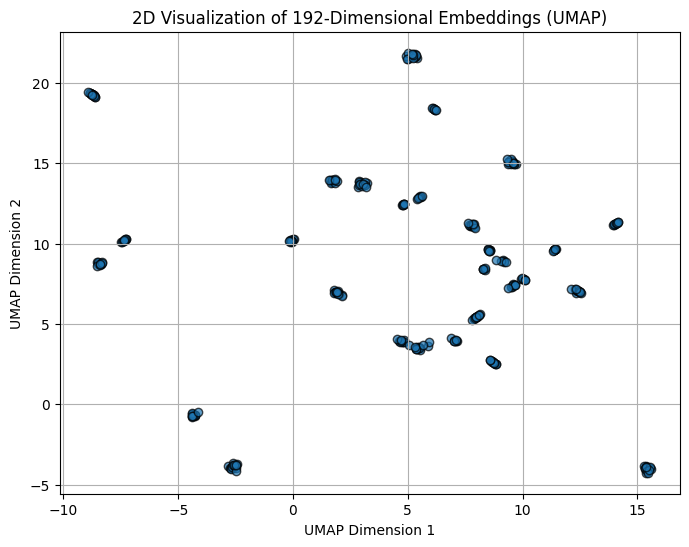

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap  # umap-learn

# List all .npy files in the folder
npy_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]
print(f"Found {len(npy_files)} .npy files.")

# Load all embeddings into a list and then stack them into an array
embeddings = []
for file in npy_files:
    emb = np.load(file)
    # If the file has an extra singleton dimension at axis 1, remove it.
    if emb.ndim == 3 and emb.shape[1] == 1:
        emb = np.squeeze(emb, axis=1)
    embeddings.append(emb)

# Instead of np.array(embeddings), use np.vstack to create a 2D array.
# This will stack all rows from each file together.
embeddings = np.vstack(embeddings)  # Final shape: (n_files * 343, 192)
print("Embeddings shape:", embeddings.shape)

# Reduce the embeddings to 2 dimensions using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings)
print("2D embeddings shape:", embeddings_2d.shape)

# Plot the UMAP projection
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, edgecolor='k')
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("2D Visualization of 192-Dimensional Embeddings (UMAP)")
plt.grid(True)
plt.show()


## **Feature Engineering**

In this step, we extract, compare, and transform voiceprint and prosody embeddings to create meaningful features for speaker verification.

### **1. Extracting Voiceprint and Prosody Embeddings**
We begin by extracting two types of embeddings:  
- **Voiceprint embeddings** (using **ECAPA-TDNN**) – These capture the **identity** of the speaker.  
- **Prosody embeddings** (using **Tacotron2**) – These capture the **intonation and rhythm** of the speaker’s speech.

Each speaker has multiple utterances, and we **combine speaker embeddings** by averaging them to obtain a **mean speaker embedding** for each speaker.

#### **Example Data Format:**
| Speaker_ID | Utterance_ID  | Label  |
|------------|--------------|--------|
| 1272       | 1272-135031-0000 | target |
| 1272       | 1272-135031-0001 | target |

Here, we compare **speaker ID** and **utterance ID** to generate features.

---

### **2. Computing Product and Difference Features**
To compare embeddings, we calculate:
1. **Scalar Product** – Measures similarity between **speaker embedding** and **utterance embedding**.
2. **Scalar Difference** – Captures the difference between the two embeddings.

We use **scalar values** to reduce noise and make the features more interpretable.  
- **Low product & difference values** → Suggests a strong match between embeddings (same speaker).  
- **High product & difference values** → Suggests a weak match (different speakers).  

These calculations are applied to both **prosody** and **voiceprint** embeddings.

---

### **3. Computing Manhattan Distance**
To further quantify differences, we compute the **Manhattan distance** between **speaker and utterance embeddings**.  

**Why Manhattan Distance?**  
- It is **robust** to high-dimensional data.  
- It helps measure how far an utterance embedding is from the speaker’s mean embedding.

After adding this, the feature set includes **scalar product, scalar difference, and Manhattan distance**.

---

### **4. Clustering Speakers and Utterances**
Next, we apply **clustering** to group embeddings:  
- **Speaker cluster** – Groups embeddings by speaker.  
- **Utterance cluster** – Groups embeddings by specific utterances.

We introduce a **binary feature**:
- `1` → If both embeddings belong to the same cluster.  
- `0` → If they belong to different clusters.

---

### **5. Correlation Matrix**
Finally, we compute a **correlation matrix** to examine how strongly each feature is related to speaker identity. This helps understand which features contribute the most to speaker verification.

---

### **Summary of Features**
| Feature Type            | Description |
|-------------------------|-------------|
| **Scalar Product**       | Measures similarity between embeddings. |
| **Scalar Difference**    | Measures variation between embeddings. |
| **Manhattan Distance**   | Measures overall distance between embeddings. |
| **Clustering Feature**   | Indicates if embeddings belong to the same cluster. |

Below is the correlation matrix showing the relationship between these features.

In [ ]:
"""
This code processes trial data for a given dataset (training, validation, or test) by loading 
the enrollment and trial embeddings for two modalities ("voiceprint" and "prosody") from specified 
folders. It computes element-wise product and absolute difference features separately, and then 
computes the Manhattan (L1) distance for the voiceprint modality. These feature vectors are built 
in a modular fashion: first the product and difference features are computed and concatenated, 
then the Manhattan distance is appended. Labels are converted to binary (target = 1, nontarget = 0).
"""

# Process each dataset:
results = {}
for ds in ['training_set', 'validation_set', 'test_set']:
    trial_df = trials_dfs[ds]
    X, y = process_trials_for_dataset(trial_df, ds, folder_paths)
    results[ds] = {'features': X, 'labels': y}
    print(f"{ds} processed: X shape = {X.shape}, y shape = {y.shape}")

Processing training_set trials: 100%|██████████| 28710/28710 [00:07<00:00, 3654.65it/s]


training_set processed: X shape = (28710, 5), y shape = (28710,)


Processing validation_set trials: 100%|██████████| 1500/1500 [00:00<00:00, 3622.20it/s]


validation_set processed: X shape = (1500, 5), y shape = (1500,)


Processing test_set trials: 100%|██████████| 21650/21650 [00:05<00:00, 3620.31it/s]

test_set processed: X shape = (21650, 5), y shape = (21650,)


clustering

In [ ]:
###############################################
# Module 1: Enroll Data Processing & Clustering
###############################################

def load_enroll_data(enroll_folder_path):
    """
    Loads enroll embeddings from a folder of .npy files.
    Assumes each file is a 1D embedding of length 192 and the speaker ID is the first part of the filename (split by '-').
    
    Returns:
        X_enroll: numpy array of shape (n_samples, 192)
        enroll_speaker_ids: list of speaker IDs as strings
    """
    enroll_files = [os.path.join(enroll_folder_path, f) for f in os.listdir(enroll_folder_path) if f.endswith('.npy')]
    print(f"Found {len(enroll_files)} enroll files.")
    
    enroll_embeddings = []
    enroll_speaker_ids = []
    for file in enroll_files:
        emb = np.load(file)
        emb = np.squeeze(emb)  # Remove singleton dimensions
        enroll_embeddings.append(emb)
        base = os.path.basename(file)
        speaker_id = base.split('-')[0]
        enroll_speaker_ids.append(speaker_id)
    
    X_enroll = np.array(enroll_embeddings)
    print("Enroll embeddings shape:", X_enroll.shape)
    return X_enroll, enroll_speaker_ids

def reduce_embeddings_umap(X, n_components=2, random_state=42):
    """
    Reduces high-dimensional embeddings using UMAP.
    
    Returns:
        umap_model: fitted UMAP model.
        X_umap: the reduced embeddings.
    """
    umap_model = umap.UMAP(n_components=n_components, random_state=random_state)
    X_umap = umap_model.fit_transform(X)
    return umap_model, X_umap

def cluster_enroll_hdbscan(X_umap, min_cluster_size=5, min_samples=5):
    """
    Runs HDBSCAN on UMAP-projected enroll embeddings.
    
    Returns:
        hdbscan_labels: array of cluster labels.
    """
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    hdbscan_labels = clusterer.fit_predict(X_umap)
    print("HDBSCAN labels:", hdbscan_labels)
    num_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
    print(f"Number of HDBSCAN clusters (excluding noise): {num_clusters}")
    return hdbscan_labels

def get_speaker_cluster_mapping(enroll_speaker_ids, hdbscan_labels):
    """
    For each speaker (from enroll data), computes the majority cluster label based on HDBSCAN labels.
    
    Returns:
        speaker_cluster_mapping: dict mapping speaker_id to majority cluster label.
    """
    speaker_to_labels = defaultdict(list)
    for speaker_id, label in zip(enroll_speaker_ids, hdbscan_labels):
        if label != -1:  # Consider only non-noise points.
            speaker_to_labels[speaker_id].append(label)
    speaker_cluster_mapping = {}
    for speaker_id, labels in speaker_to_labels.items():
        if labels:
            majority_label = Counter(labels).most_common(1)[0][0]
            speaker_cluster_mapping[speaker_id] = majority_label
    print("Speaker to Cluster Mapping (from enroll):")
    for speaker, cluster in speaker_cluster_mapping.items():
        print(f"Speaker {speaker}: Cluster {cluster}")
    return speaker_cluster_mapping

def compute_cluster_centroids(X_umap, hdbscan_labels):
    """
    Computes centroids in UMAP space for each cluster label (excluding noise).
    
    Returns:
        cluster_centroids: dict mapping cluster label to centroid (array of shape (2,)).
    """
    cluster_points = defaultdict(list)
    for point, label in zip(X_umap, hdbscan_labels):
        if label != -1:
            cluster_points[label].append(point)
    cluster_centroids = {label: np.mean(points, axis=0) for label, points in cluster_points.items()}
    return cluster_centroids

###############################################
# Module 2: Trial Processing & Feature Engineering
###############################################

def assign_cluster_to_trial(trial_embedding, umap_model, cluster_centroids):
    """
    Given a trial utterance embedding (192-dim), transforms it using the provided umap_model,
    then assigns it to the cluster whose centroid (in UMAP space) is most similar (via cosine similarity).
    
    Returns:
        assigned_label: the cluster label assigned to the trial utterance.
    """
    # Transform the trial embedding (reshape to (1, -1) as needed)
    X_trial_umap = umap_model.transform(trial_embedding.reshape(1, -1))
    best_label = None
    best_sim = -1
    for label, centroid in cluster_centroids.items():
        # Compute cosine similarity between trial UMAP and the centroid.
        sim = cosine_similarity(X_trial_umap, centroid.reshape(1, -1))[0, 0]
        if sim > best_sim:
            best_sim = sim
            best_label = label
    return best_label

def get_cluster_match(speaker_id, trial_embedding, umap_model, speaker_cluster_mapping, cluster_centroids):
    """
    Main function that computes the "Cluster Match" feature for a single trial utterance.
    
    Steps:
      1. Transform the trial embedding using the provided UMAP model.
      2. Assign the trial embedding to a cluster based on cosine similarity to enroll cluster centroids.
      3. Retrieve the majority cluster label for the given speaker (from enroll data).
      4. Return 1 if the trial's assigned cluster matches the speaker's enrolled cluster, else 0.
    
    Returns:
        cluster_match: 1 if match, 0 otherwise.
    """
    # Get the trial's assigned cluster
    trial_assigned_cluster = assign_cluster_to_trial(trial_embedding, umap_model, cluster_centroids)
    # Get the enroll (majority) cluster for this speaker
    enroll_cluster_for_speaker = speaker_cluster_mapping.get(speaker_id, -1)
    # Compare and return the binary feature
    cluster_match = 1 if trial_assigned_cluster == enroll_cluster_for_speaker else 0
    return cluster_match

def process_enroll_data_for_dataset(ds, folder_paths):
    """
    Processes the enroll embeddings for a given dataset.
    Uses folder_paths['{ds}_set']['voiceprint']['speaker_emb_path'].
    
    Returns:
      umap_model: fitted UMAP model.
      speaker_cluster_mapping: dict mapping speaker ID to majority cluster.
      cluster_centroids: dict mapping HDBSCAN cluster to centroid.
    """
    enroll_folder_path = folder_paths[f'{ds}']['voiceprint']['speaker_emb_path']
    X_enroll, enroll_speaker_ids = load_enroll_data(enroll_folder_path)
    umap_model, X_umap_2d = reduce_embeddings_umap(X_enroll, n_components=2, random_state=42)
    hdbscan_labels = cluster_enroll_hdbscan(X_umap_2d, min_cluster_size=5, min_samples=5)
    speaker_cluster_mapping = get_speaker_cluster_mapping(enroll_speaker_ids, hdbscan_labels)
    cluster_centroids = compute_cluster_centroids(X_umap_2d, hdbscan_labels)
    return umap_model, speaker_cluster_mapping, cluster_centroids

Adding clustering for each set

In [ ]:
# # Suppress the specific FutureWarning related to 'force_all_finite'
# warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)

# # Process enroll data for the training set
# umap_model_train, speaker_cluster_mapping_train, cluster_centroids_train = process_enroll_data_for_dataset('training_set', folder_paths)
# trial_path_train = folder_paths['training_set']['voiceprint']['trial_path']

# # Process trial data for training set to compute the new cluster match feature
# # (Assume trial_df for training is stored in trials_dfs['training_set'])
# trial_df_train = trials_dfs['training_set']
# cluster_feature_list_train = []

# for idx, row in tqdm(trial_df_train.iterrows(), total=len(trial_df_train), desc="Processing training_set trials"):
#     speaker_id = str(row['Speaker_ID'])
#     utterance_id = str(row['Utterance_ID'])
#     # Find the corresponding trial embedding file (assumes filename begins with utterance_id)
#     trial_files = glob.glob(os.path.join(trial_path_train, f"{utterance_id}*.npy"))
#     if not trial_files:
#         cluster_feature_list_train.append(np.array([0]))
#     else:
#         trial_file = trial_files[0]
#         trial_embedding = np.squeeze(np.load(trial_file))
#         # Compute cluster match (0 or 1)
#         cluster_match = get_cluster_match(speaker_id, trial_embedding, umap_model_train,
#                                           speaker_cluster_mapping_train, cluster_centroids_train)
#         cluster_feature_list_train.append(np.array([cluster_match]))

# new_feature_array_train = np.array(cluster_feature_list_train)  # shape (n_samples, 1)
# # Retrieve existing features for training set
# X_orig_train = results['training_set']['features']  # previously computed features
# X_updated_train = np.hstack([X_orig_train, new_feature_array_train])
# results['training_set']['features'] = X_updated_train
# print("Training set updated: X shape =", X_updated_train.shape)

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Found 343 enroll files.
Enroll embeddings shape: (343, 192)
HDBSCAN labels: [11 11 11 11 11 11 11 11 11 11 27 27 27 27 27 27 27 27 27 27 27 25 25 25
 25 25 13 13 13 13 13 13 13  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 21 21 21 21 21 21 21 21 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 18 18 18 18 18 18 18 18 18 18 18
 18  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  4  4  4  4  4
  4  4  4  4  4  4  4 16 16 16 16 16 16 16 16 16 16 16 16 16 24 24 24 24
 24 24 22 22 22 22 22 22 22 22 22  3  3  3  3  3  3  3  3  3  3  3  3 25
  3  3  3  3  3 23 23 23 23 23 23 23 14 14 14 14 14 14 14  5  5  5  5  5
  5  5  5  5 20 20 20 20 20 20 20 20 20 20 20 20 20 20 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 10 10 10 10 10 10 10 10 10 10 10 10  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8 26 26 26 26 26 26 26 26 12 12
 12 12 12 12 12 12 12 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1

Processing training_set trials: 100%|██████████| 28710/28710 [04:35<00:00, 104.16it/s]

Training set updated: X shape = (28710, 6)


In [ ]:
# # Suppress the specific FutureWarning related to 'force_all_finite'
# warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)

# # Process enroll data for the validation set
# umap_model_val, speaker_cluster_mapping_val, cluster_centroids_val = process_enroll_data_for_dataset('validation_set', folder_paths)
# trial_path_val = folder_paths['validation_set']['voiceprint']['trial_path']

# # Process trial data for validation set
# trial_df_val = trials_dfs['validation_set']
# cluster_feature_list_val = []

# for idx, row in tqdm(trial_df_val.iterrows(), total=len(trial_df_val), desc="Processing validation_set trials"):
#     speaker_id = str(row['Speaker_ID'])
#     utterance_id = str(row['Utterance_ID'])
#     trial_files = glob.glob(os.path.join(trial_path_val, f"{utterance_id}*.npy"))
#     if not trial_files:
#         cluster_feature_list_val.append(np.array([0]))
#     else:
#         trial_file = trial_files[0]
#         trial_embedding = np.squeeze(np.load(trial_file))
#         cluster_match = get_cluster_match(speaker_id, trial_embedding, umap_model_val,
#                                           speaker_cluster_mapping_val, cluster_centroids_val)
#         cluster_feature_list_val.append(np.array([cluster_match]))

# new_feature_array_val = np.array(cluster_feature_list_val)  # shape (n_samples, 1)
# X_orig_val = results['validation_set']['features']
# X_updated_val = np.hstack([X_orig_val, new_feature_array_val])
# results['validation_set']['features'] = X_updated_val
# print("Validation set updated: X shape =", X_updated_val.shape)


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Found 289 enroll files.
Enroll embeddings shape: (289, 192)
HDBSCAN labels: [18 15 18 18 18 18 18 18 18 -1 18 18 18 18 18 20 20 20 20 20 20 20  8  8
  8  8  8  8  8  8  8  8  8  8 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 11 11 11 11 11 11 19 19 19 19 19 19 19 19 19 19 19  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2 13 13 13 13 13 13 13 13 23 23 23 23
 23 23 23 23 23 23 23 23 23 23  5  5  5  5  5  5  5  5  5  5  5  5  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  6  6  6  6  6  6  6
  6  6  6  6  6 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 21 21 21 21 21 21 21  9  9  9  9  9  9  9  9  9 12 12 12 12 12
 12 12 12 12 12 12 12 12 12  4  4  4  4  4  4  4  4  4  4  4  4 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 22 22 22 22 22 22 22 22 14 14 14
 14 14 14 14 14 14 14  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  7  7  7  7  7  7
  7]
Number of HDBSCAN clusters (excluding noise

Processing validation_set trials: 100%|██████████| 1500/1500 [00:12<00:00, 120.04it/s]

Validation set updated: X shape = (1500, 6)


In [ ]:
# # Suppress the specific FutureWarning related to 'force_all_finite'
# warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)

# # Process enroll data for the test set
# umap_model_test, speaker_cluster_mapping_test, cluster_centroids_test = process_enroll_data_for_dataset('test_set', folder_paths)
# trial_path_test = folder_paths['test_set']['voiceprint']['trial_path']

# # Process trial data for test set
# trial_df_test = trials_dfs['test_set']
# cluster_feature_list_test = []

# for idx, row in tqdm(trial_df_test.iterrows(), total=len(trial_df_test), desc="Processing test_set trials"):
#     speaker_id = str(row['Speaker_ID'])
#     utterance_id = str(row['Utterance_ID'])
#     trial_files = glob.glob(os.path.join(trial_path_test, f"{utterance_id}*.npy"))
#     if not trial_files:
#         cluster_feature_list_test.append(np.array([0]))
#     else:
#         trial_file = trial_files[0]
#         trial_embedding = np.squeeze(np.load(trial_file))
#         cluster_match = get_cluster_match(speaker_id, trial_embedding, umap_model_test,
#                                           speaker_cluster_mapping_test, cluster_centroids_test)
#         cluster_feature_list_test.append(np.array([cluster_match]))

# new_feature_array_test = np.array(cluster_feature_list_test)  # shape (n_samples, 1)
# X_orig_test = results['test_set']['features']
# X_updated_test = np.hstack([X_orig_test, new_feature_array_test])
# results['test_set']['features'] = X_updated_test
# print("Test set updated: X shape =", X_updated_test.shape)


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Found 438 enroll files.
Enroll embeddings shape: (438, 192)
HDBSCAN labels: [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24  4  4  4  4  4  4
  4  4  4  4  4 15 15 15 15 15 15 15 15 15 15 15 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 10 10 10 10 10 10 10 10 10 10 12 12 12 12 12 12 12 12 12 12
 12 27 27 27 27 27 27 27 27 27 27 27 27 17 17 17 17 17 17 17 17 17 17 17
 17  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7 22 22 22 22 22 22 22 22 22 22 22  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11 11 11 11 11 11 11 11 11 11
 11 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23

Processing test_set trials: 100%|██████████| 21650/21650 [03:23<00:00, 106.29it/s]


Test set updated: X shape = (21650, 6)


In [ ]:
datasets = ['training_set', 'validation_set', 'test_set']

for ds in datasets:
    # Create the subdirectory "feature_vectors" in the dataset folder
    save_folder = folder_paths[ds]["feature_vector"]
    os.makedirs(save_folder, exist_ok=True)
    
    # Define the file paths
    features_file = os.path.join(save_folder, 'features.npy')
    labels_file = os.path.join(save_folder, 'labels.npy')
    
    # Save the numpy arrays
    np.save(features_file, results[ds]['features'])
    np.save(labels_file, results[ds]['labels'])

print("Data saved successfully.")

Data saved successfully.


## Correlation Matrix